In [43]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [44]:
results_fldr = "mask-rcnn.pytorch/Outputs/e2e_mask_rcnn_R-101-FPN_2x/Sep22-23-46-01_aurora_step/test"

In [45]:
runs = os.listdir(results_fldr)

In [46]:
run = runs[0]

In [47]:
bb_json = os.path.join(
    results_fldr, run, "bbox_isic_2018_val_results.json")

In [48]:
with open(bb_json, "r") as f:
    bb_results = json.load(f)

In [49]:
# image_id + score means the earliest images will go first
# (always >=1 apart). Subtracting the score means the best one will be
# least and therefore first
res_srted = sorted(bb_results, key=lambda d: d["image_id"] - d["score"])

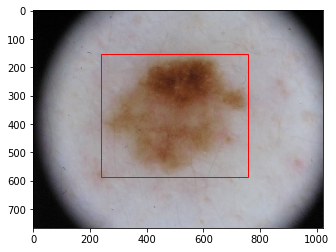

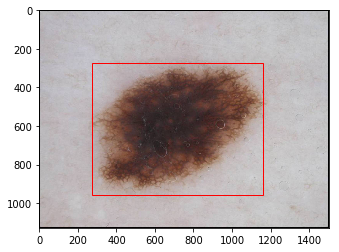

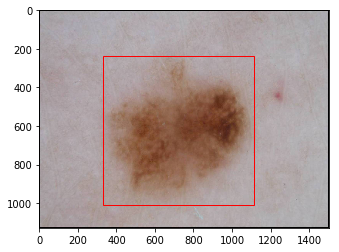

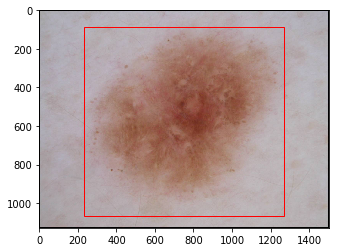

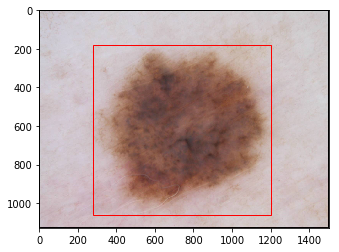

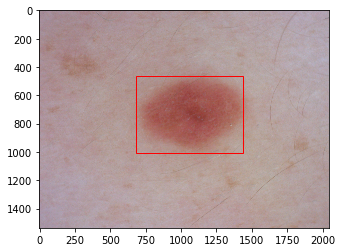

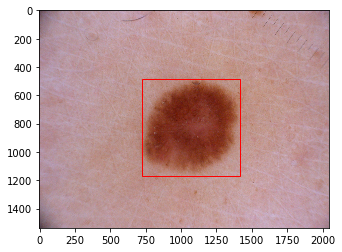

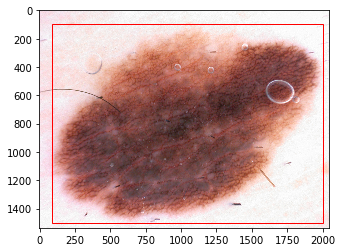

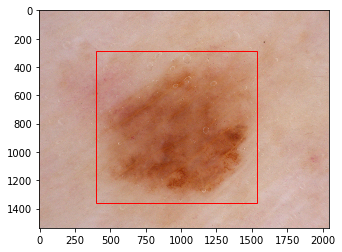

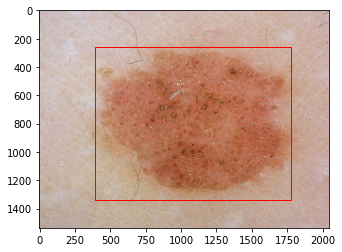

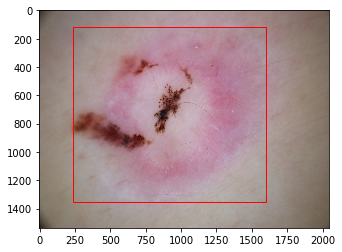

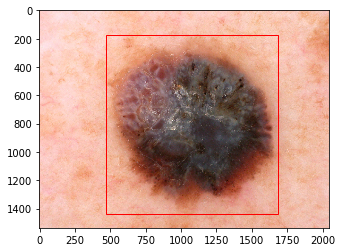

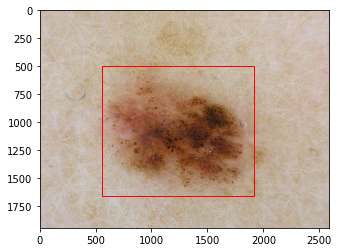

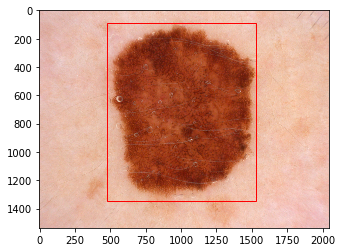

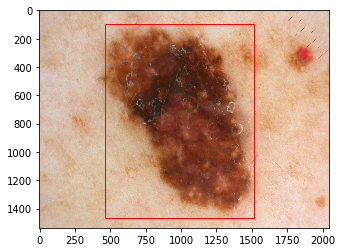

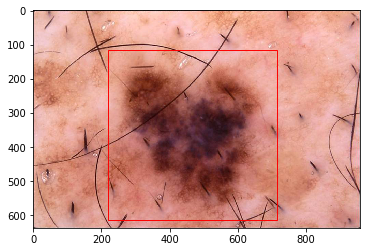

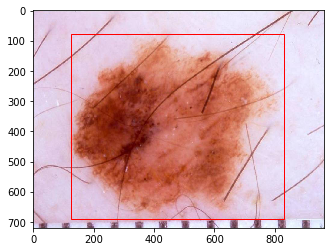

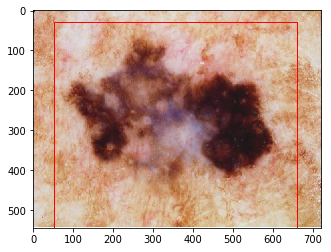

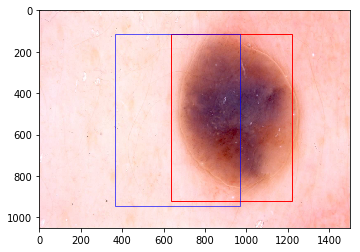

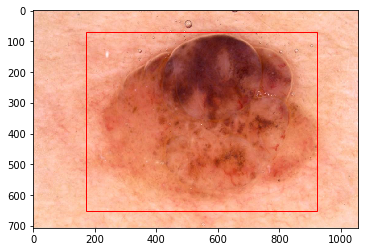

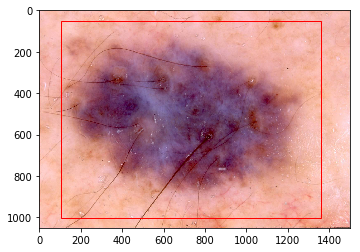

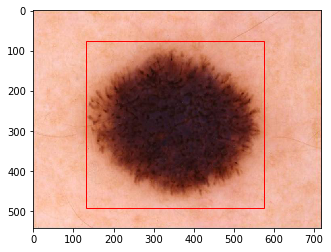

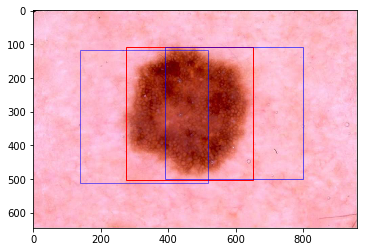

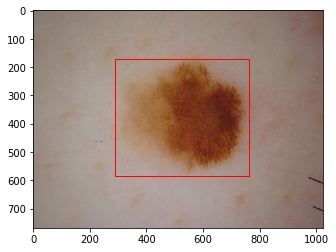

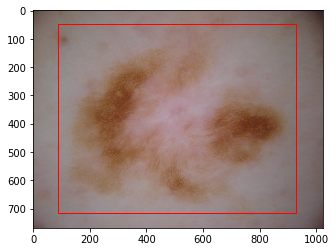

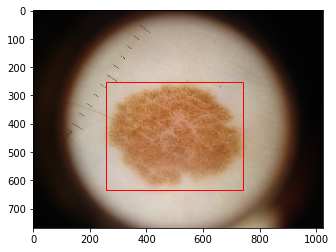

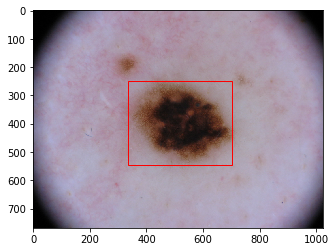

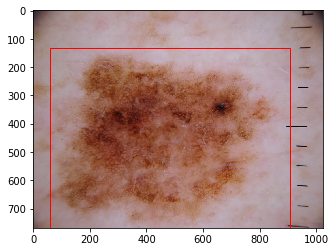

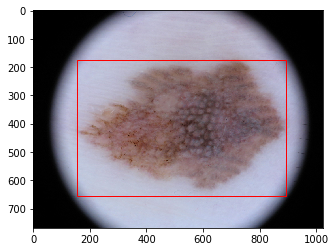

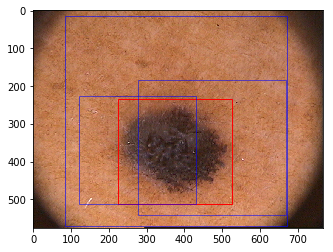

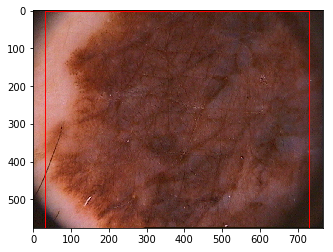

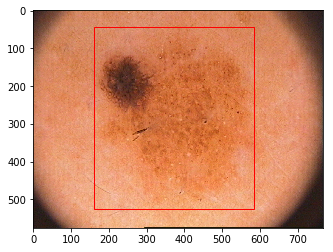

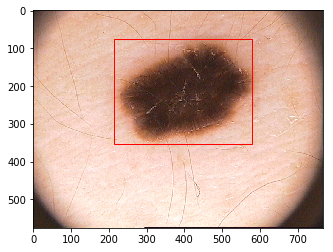

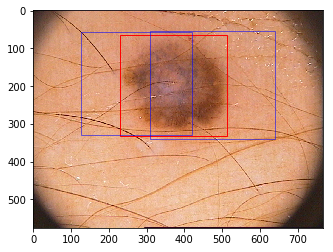

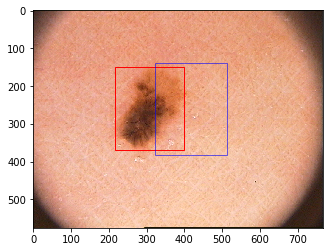

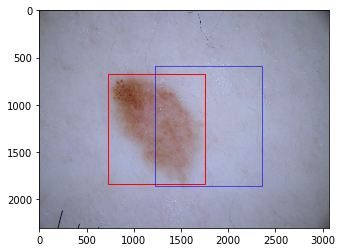

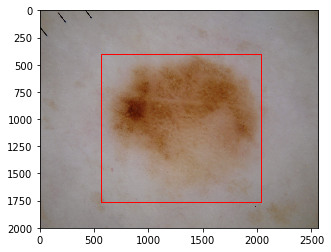

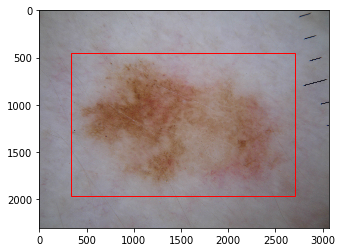

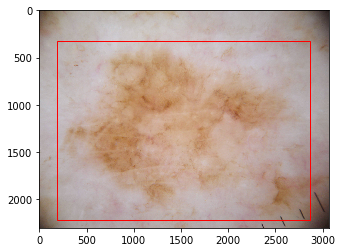

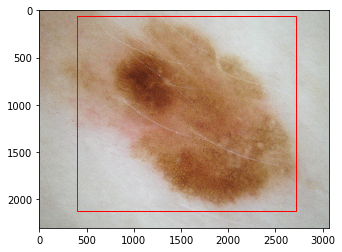

In [50]:
i = 0
while i < 50:
    res_0 = res_srted[i]
    isic_id = (res_0["image_id"] - 1) / 4
    if isic_id != int(isic_id):
        assert False
    isic_id = int(isic_id)
    path = f"/data/sd0/here/isic_fmt/images/val2018/ISIC_{str(isic_id).zfill(7)}.jpg"
    im = Image.open(path)

    # Create figure and axes
    fig,ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    while res_0["image_id"] == res_srted[i]["image_id"]:
        if res_0 == res_srted[i]:
            color = 'r'
        else:
            color = 'b'
        bbox = res_srted[i]["bbox"]
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox[0],bbox[1]),
                                 bbox[2],
                                 bbox[3],
                                 linewidth=1,
                                 edgecolor=color,
                                 facecolor='none',
                                 alpha=0.5 + 0.5 * res_srted[i]["score"])
        # Add the patch to the Axes
        ax.add_patch(rect)
        i += 1

    plt.show()

In [51]:
res_by_id = {}
for res in bb_results:
    isic_id = (res["image_id"] - 1) / 4
    if isic_id != int(isic_id):
        assert False
    isic_id = int(isic_id)
    try:
        res_by_id[isic_id].append(res)
    except KeyError:
        res_by_id[isic_id] = [res]

In [52]:
import math
import cv2
import numpy as np

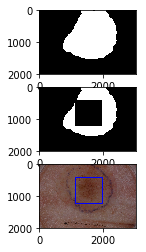

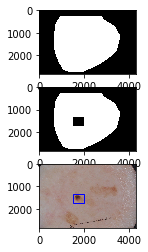

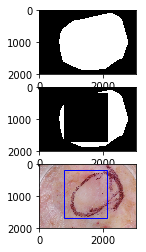

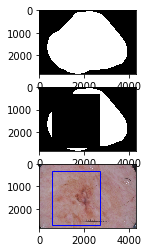

In [53]:
all_ = []
for filename in os.listdir("/data/sd0/here/isic_fmt/images/val2018"):
    base_filename = os.path.splitext(filename)[0]
    id_ = int(base_filename[5:])
    if id_ not in res_by_id:
        print(f"id {id_} failed.")
        all_.append(1)
        continue
    mask_filename = base_filename + "_segmentation.png"
    mask_path = os.path.join("/data/sd0/here/isic_fmt/masks",
                             mask_filename)
    _, mask = cv2.threshold(
        cv2.imread(mask_path, 0),
        256 // 2, 255, cv2.THRESH_BINARY)
    bboxes = res_by_id[id_]
    best = max(bboxes, key=lambda x: x["score"])
    best_bbox = best["bbox"]
    bottom, left, width, height = best_bbox
    
    bottom = math.ceil(bottom)
    left = math.floor(left)
    width = math.ceil(width) + 1
    height = math.ceil(height) + 1
    
    mask_height, mask_width = mask.shape

    c0 = bottom
    cf = bottom + width
    r0 = left
    rf = left + height

    mask_size = mask.sum()
    mask_not_bb = np.empty_like(mask)
    mask_not_bb[:] = mask
    mask_not_bb[r0:rf, c0:cf] = 0
    missing = mask_not_bb.sum()
    if missing / mask_size > 0.3:
        fig,axes = plt.subplots(3)
        axes[0].imshow(mask, cmap="gray")
        axes[1].imshow(mask_not_bb, cmap="gray")
        img_path = os.path.join(
            "/data/sd0/here/isic_fmt/images/val2018", filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[2].imshow(img)

        rect = patches.Rectangle((bottom, left),
                                 width,
                                 height,
                                 linewidth=1,
                                 edgecolor='b',
                                 facecolor='none')
        # Add the patch to the Axes
        axes[2].add_patch(rect)
    all_.append(missing / mask_size)


In [54]:
np.mean(all_)
np.std(all_)

0.08742566453286034

In [56]:
import multiprocessing as mp


def proc(res_by_id, filename):
    base_filename = os.path.splitext(filename)[0]
    id_ = int(base_filename[5:])
    if id_ not in res_by_id:
        return 1
    mask_filename = base_filename + "_segmentation.png"
    mask_path = os.path.join("/data/sd0/here/isic_fmt/masks",
                             mask_filename)
    _, mask = cv2.threshold(
        cv2.imread(mask_path, 0),
        256 // 2, 255, cv2.THRESH_BINARY)
    bboxes = res_by_id[id_]
    best = max(bboxes, key=lambda x: x["score"])
    bottom, left, width, height = best["bbox"]

    bottom = math.floor(bottom)
    left = math.floor(left)
    width = math.ceil(width) + 1
    height = math.ceil(height) + 1

    c0 = bottom
    cf = bottom + width
    r0 = left
    rf = left + height

    mask_size = mask.sum()
    mask[r0:rf, c0:cf] = 0
    return mask.sum() / mask_size

data = {}

results_fldr = "mask-rcnn.pytorch/Outputs/e2e_mask_rcnn_R-101-FPN_2x/Sep22-23-46-01_aurora_step/test"
runs = os.listdir(results_fldr)
runs = sorted(runs,
              key=lambda x: int("".join([c for c in x if c.isnumeric()])))
with mp.Pool() as p:
    for run in runs:
        bb_json = os.path.join(
            results_fldr, run, "bbox_isic_2018_val_results.json")
        try:
            with open(bb_json, "r") as f:
                bb_results = json.load(f)
        except Exception as e:
            print(e)
            continue
        res_by_id = {}
        for res in bb_results:
            isic_id = (res["image_id"] - 1) / 4
            if isic_id != int(isic_id):
                assert False
            isic_id = int(isic_id)
            try:
                res_by_id[isic_id].append(res)
            except KeyError:
                res_by_id[isic_id] = [res]

        all_ = p.starmap(
            proc,
            ((res_by_id, f) for f in os.listdir("/data/sd0/here/isic_fmt/images/val2018")))

        data[run] = all_

        print(run, "mean:", np.mean(all_), "std:", np.std(all_))

model_step499.pth mean: 0.10871227664991595 std: 0.1888066216288446
model_step1499.pth mean: 0.049142971915848356 std: 0.14241444176083998
model_step2499.pth mean: 0.0230906226132715 std: 0.0985074830061218
model_step3499.pth mean: 0.03149848978610647 std: 0.08257317765461927
model_step4499.pth mean: 0.06350197885979844 std: 0.1780757650441441
model_step5499.pth mean: 0.054523956632099635 std: 0.12772258368998832
model_step6499.pth mean: 0.019412445155821124 std: 0.07968070716263234
model_step7499.pth mean: 0.021031421597637948 std: 0.09098442014892934
model_step8499.pth mean: 0.03387231574809661 std: 0.10601184402614701
model_step9499.pth mean: 0.02940381856113968 std: 0.06965704425522673
model_step10499.pth mean: 0.016726597504191584 std: 0.045013636780092445
model_step11499.pth mean: 0.034575103045028824 std: 0.11198200736016095
model_step12499.pth mean: 0.02810764724533622 std: 0.09086174199406157
model_step13499.pth mean: 0.03784743988746465 std: 0.10328191836842429
model_step1449

In [57]:
newdata = {}
for k, v in data.items():
    newk = int("".join([c for c in k if c.isnumeric()]))
    newdata[newk] = v

In [58]:
import pandas as pd

In [59]:
df = pd.DataFrame(newdata)

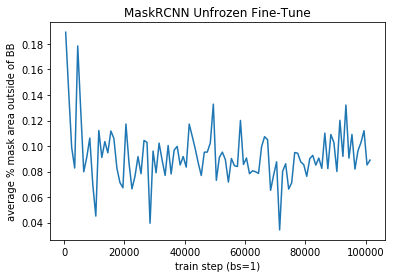

In [62]:
ax = df.std().plot()
ax.set_title("MaskRCNN Unfrozen Fine-Tune")
ax.set_ylabel("average % mask area outside of BB")
ax.set_xlabel("train step (bs=1)")
ax.figure.savefig("unfrozen_finetune_mean.png", dpi=300)

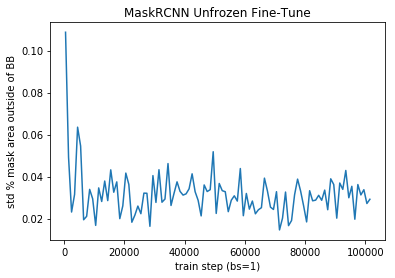

In [63]:
ax = df.mean().plot()
ax.set_title("MaskRCNN Unfrozen Fine-Tune")
ax.set_ylabel("std % mask area outside of BB")
ax.set_xlabel("train step (bs=1)")
ax.figure.savefig("unfrozen_finetune_std.png", dpi=300)